In [11]:
import numpy as np
from numpy import log
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import os
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA


In [2]:
spy = pd.read_csv('spy_processed.csv')

In [ ]:
#spy.head()

In [3]:
cp = spy.iloc[:,[0,6,7,11]]
cp = cp.rename({'Close' : 'clo', 'Adj Close' : 'adc', 'Unnamed: 0.1' : 'no'}, axis =1 )

# find order of differencing -- d

In [ ]:
plot_acf(cp.adc.dropna());

In [ ]:
plot_acf(cp.adc.diff(10).dropna());

In [ ]:
result = adfuller(cp.adc)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
# first differencing

result = adfuller(cp.adc.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:

# Adf Test: 1
ndiffs(cp.adc, test='adf')

# KPSS test: 2
ndiffs(cp.adc, test='kpss')

# PP test: 1
ndiffs(cp.adc, test='pp') 

# Order of AR term -- p

In [ ]:
plot_pacf(cp.adc.diff(2).dropna(), method = 'ywm')

plt.show()

#lag : exceed significance level -- we choose 1

# Order of MA term -- q

In [ ]:
plot_acf(cp.adc.diff(1).dropna());
# we choose q = 2

# ARIMA Model

In [ ]:
model = ARIMA(cp.adc, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# residual plot

residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')


# auto ARIMA

In [ ]:
model_auto = pm.auto_arima(cp.ret, start_p = 1, start_q = 1,
                      test = 'adf',       
                      max_p = 3, max_q = 3, 
                      m = 1,              
                      d = None,           
                      seasonal = False,   
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

print(model_auto.summary())

# Predictions and prediction error

In [38]:
###### TEST --  DELETE in final version

begin_ind = 5000
n = 100
lag = 50

train = cp.adc[begin_ind - lag : begin_ind]
test = cp.adc[begin_ind + 1 : begin_ind + n]
history = [x for x in train]
predictions = list()
actual = list()

# walk-forward validation
for t in range(n):
    model = ARIMA(history, order=(1,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = cp.adc[begin_ind + t]
    actual.append(obs)
    history.append(obs)



In [25]:
def arima_predictions(n, begin_ind, lag, show_plot=False):
    
    
    
    train = cp.ret[begin_ind - lag : begin_ind]
    history = [x for x in train]
    predictions = list()
    actual = list()
    close_price_pred = list()

    # walk-forward validation
    for t in range(n):
        model = ARIMA(history, order=(1,0,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        
        obs = cp.ret[begin_ind + t]
        actual.append(cp.adc[begin_ind + t])
        history.append(obs)
        
        close_price_pred.append(cp.adc[begin_ind + t - 1] * (1 + yhat))
        
        
    retdf = pd.concat([pd.DataFrame(close_price_pred), pd.DataFrame(actual)], axis = 1)
    retdf.columns = ['pred', 'actual']
       
        
    mse = np.sum(np.square(retdf["pred"] - retdf["actual"]))
    print('MSE : %f' % mse)

    
    if show_plot:
            plt.plot(spy.Date[begin_ind:begin_ind+n], retdf["pred"],"o-", markersize=3, label="predicted")
            plt.plot(spy.Date[begin_ind:begin_ind+n], retdf["actual"], "o-", markersize=3, label="actual")
            #plt.fill_between(self.dates[begin_ind:begin_ind+n], ret["left_ci"], ret["right_ci"], color="b", alpha=0.1)
            plt.ylabel("Adjusted Close")
            plt.legend(loc="lower right", fontsize=20)

        
    return retdf
    

MSE : 137.721730


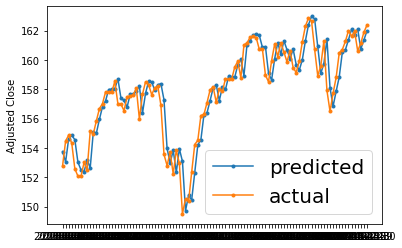

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = arima_predictions(100, 5000, 50, show_plot = True)

In [41]:
res

,pred,actual
0,153.757630,152.770416
1,153.054374,154.477875
2,154.643820,154.870636
3,154.861320,154.315674
4,154.560610,152.582535
...,...,...
95,161.697930,161.942429
96,162.106817,160.614670
97,160.737973,161.123398
98,161.344103,161.873459
